Gustavo Adolfo Tabima Luque - 201914586


Juan Carlos Eduardo Nunes Ariza-202010826


César Luis Moreno González - 201924899


---
# **Proyecto 1 Inteligencia de Negocios**



##Introducción: 
---
Reddit es una de las redes sociales emergentes más grandes actualmente, con más de un millón de usuarios alrededor del mundo, en Reddit hay muchos espacios, desde foros de arte a foros de relatos que se han hecho famosos en internet.

Reddit es también un espacio para aprovechar el anonimato de internet para abrirte a nivel emocional sin miedo a ser juzgado directamente.

En uno de los subreddits sobre suicidio y ayuda emocional se quiere hacer un análisis de Machine Learning para detectar de manera más 
eficiente los casos de suicidio, pudiendo así facilitar la moderación y acceso a ayuda en crisis por parte del Reddit.

Por ende se nos ha brindado información con los posts de este subreddit donde vamos a usar múltiples herramientas de aprendizaje para poder predecir con exatitud cuando un post es una alegoría
al suicidio y cuando es solamente Shitpost o contenido poco relacionado al mismo, con el objetivo de poder ayudar a los usuarios en crisis antes de que sea tarde

esto beneficiaría a la comunidad de Reddit dado que podríamos ayudar  a brindar más acompañamiento y filtro de contenido para que se pueda acceder a ayuda de forma más rápida y evitar trajedias.

Tenemos planteado que se usarán herramientas de aprendizaje supervisado para generar una predicción sobre si un post de reddit es de contenido suicida o no, para poder así contribuir a la detección
de estos casos de suicidio.

##Documento inicial de planeación: https://docs.google.com/document/d/1wVzt0cIFwuaGNFCQ105zyZpLEIDdfmjacdrP7OzR988/edit?usp=sharing

# 0 Descarga de las librerias utilizadas

In [ ]:
!pip install contractions
!pip install inflect
!pip install pandas-profiling==2.7.1
!pip install pandas==1.2.5
!pip install plotly

# 1. Importacion de  librerias y datos

In [ ]:
# Instalación de librerias
import pandas as pd
import numpy as np
import sys
import nltk
from pandas_profiling import ProfileReport
from sklearn.inspection import permutation_importance
import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve
from sklearn.base import BaseEstimator, ClassifierMixin
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
# Para usar KNN como clasificador
from sklearn.neighbors import KNeighborsClassifier
# Libreria para manejar el desbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
# Seaborn
import seaborn as sns 
from sklearn import tree
# librería Natural Language Toolkit, usada para trabajar con textos 
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import matplotlib.pyplot as plt

snowBallStemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Aqui vamos a cargar todas las librerias necesarias. Fue un proceso de continuo cambio, ya que cada vez que implementabamos un nuevo algoritmo de clasificación teniamos que actualizar - si era necesario- las librerias

In [ ]:
df=pd.read_csv('SuicidiosProyecto.csv', sep=',', encoding = 'utf-8')
df_duplicado = df

Se cargan los datos y por protocolo de buenas practicas le sacamos un duplicado

# 2. Entendimiento de los datos

----
Realizamos un analisis preliminar de los datos, donde podemos ver que contamos con un total de 195700 registros-filas- con tres columnas. Haciendo el analisis para encontrar datos nulos nos dimos cuenta que el archivo no cuenta con datos nulos. Sin embargo; si nos encontramos con problemas de formato a tratar más adelante.
Primero al acercarnos a los datos notamos que tienen mucha información que resulta poco útil, teniendo en cuenta que hay información abstraida de Reddit, como los bounce de posts y demás información, se tiene también que hay muchos typos en los posts, links, referencias que para los datos resultan en contenido que no nos aporta nada a lo que estamos buscando, además de tener que filtrar los emoticones y demás contenido que no nos aporta nada en el contexto de la prevención de los suicidios. 

In [ ]:
df.shape

(195700, 3)

### Análisis exploratorio de datos con Pandas Profiling

Es cogimos esta libreria porque  es un modulo libre con el cual podemos hacer un analisis exploratorio muy util en pocas lineas de codigo. Posteriormente nos permite obtener informes entendibles para cualquier persona del negocio que no sea programador.

In [ ]:
textos = df.copy()
textos['Conteo'] = [len(x) for x in textos['text']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['text']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['text']]

# Se realiza un perfilamiento de los datos con la librería pandas profiling
ProfileReport(textos)

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Como podemos observar obtenemos en una tabla las ultimas filas del archivo. Tambien obtenemos las correlaciones de pearson´s , spearman's , Kendall's T y Phil (k), las cuales nos permiten observar la dependencia lineal de dos variables cuantitativas.

Tambien encontramos que no teniamos filas duplicadas

En este punto estamos realizando análisis primarios a los datos, con Pandas Profilling Report vemos los diferentes tipos de variables, los números de variables, las observaciones  y notamos que no hay datos nulos ni duplicados.

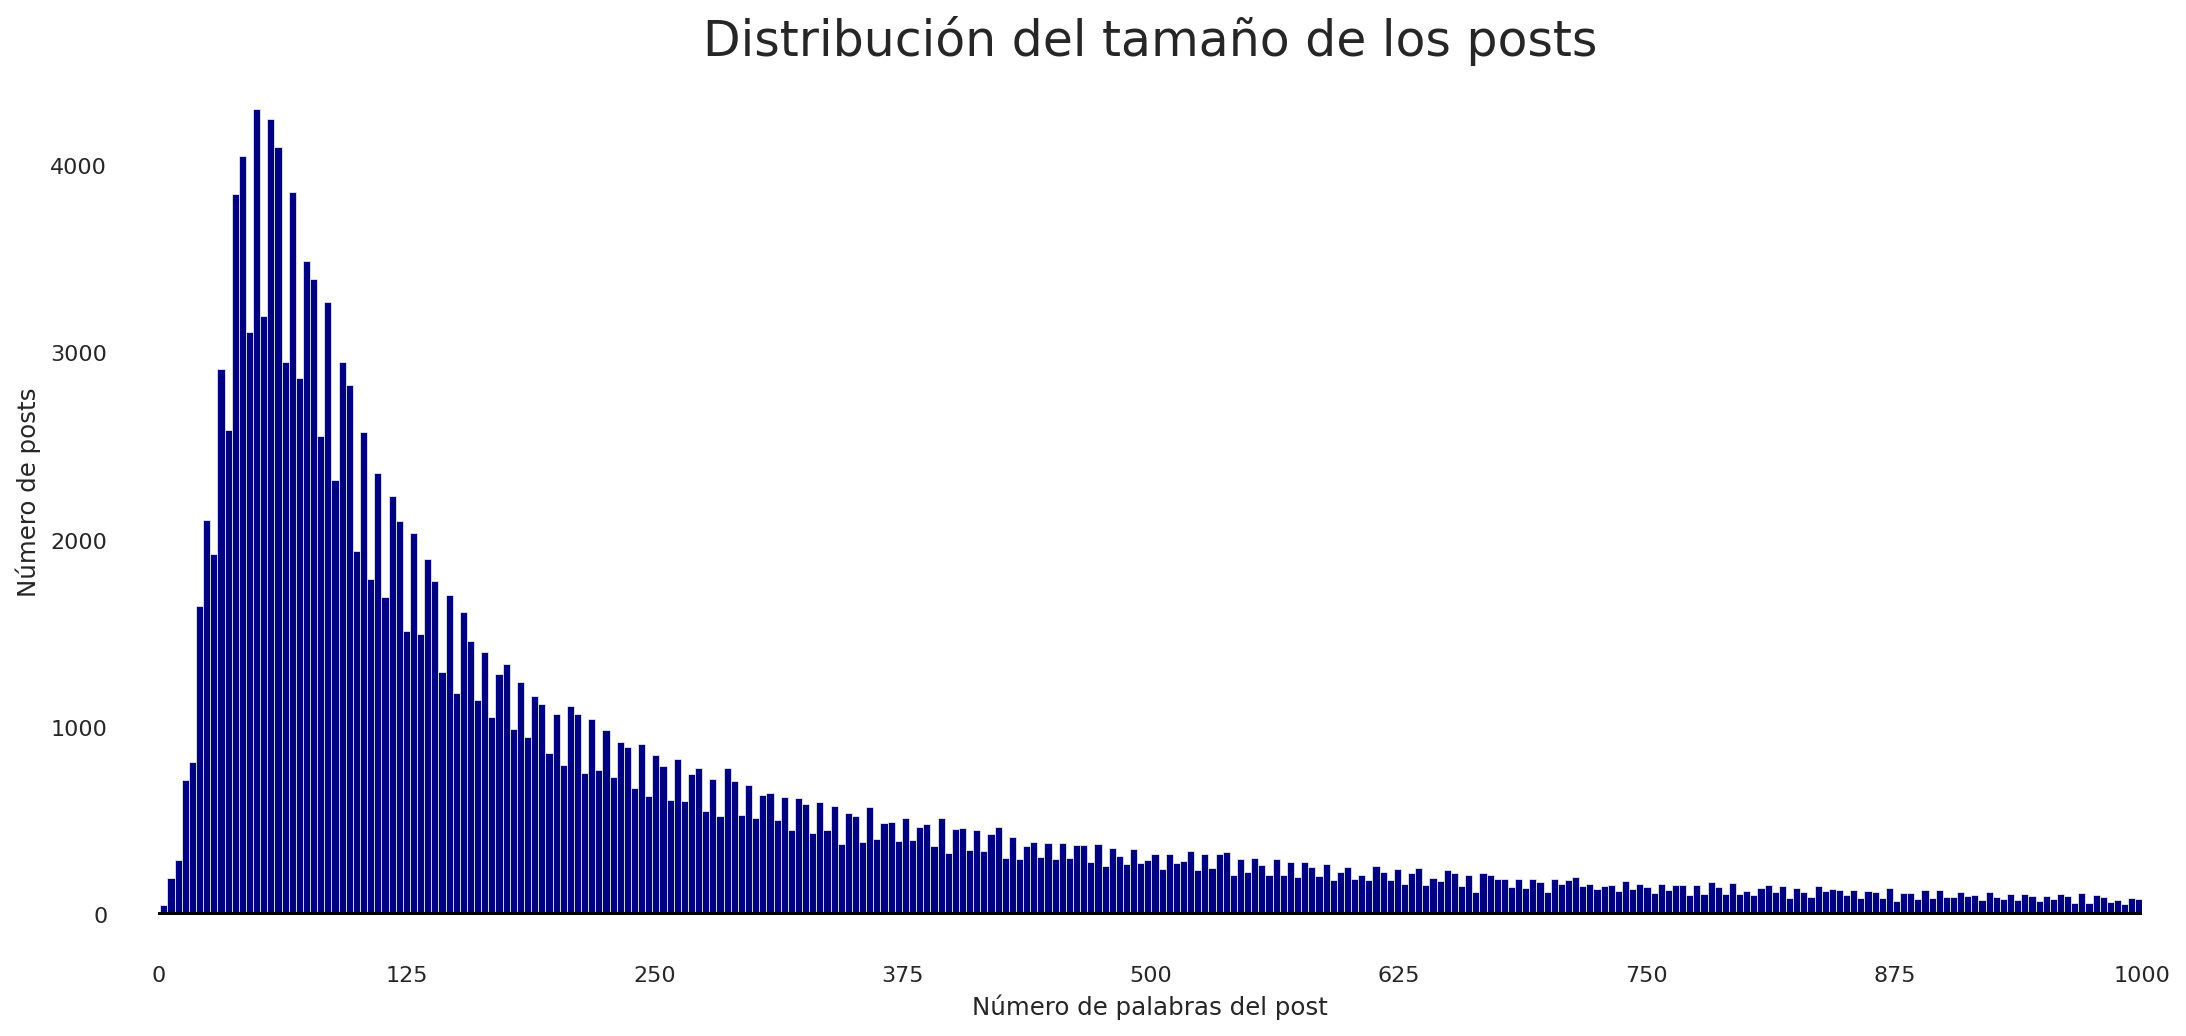

In [ ]:
doc_lens = [len(d) for d in df_duplicado["processed"]]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 50000, color='navy')
sns.kdeplot(doc_lens, color="black", shade=False)
plt.gca().set(xlim=(0, 1000), ylabel='Número de posts', xlabel='Número de palabras del post')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribución del tamaño de los posts', fontdict=dict(size=22))
plt.show()  

Notamos en el histograma presentado previamente que hay una gran cantidad de posts con más de 125 palabras, lo que significa que la gente tiende a expresarse de manera compleja y podría senirse abierta a expresar sus empociones tanto implicita como explicitamente en este tipo de espacios, lo que vuelve estos a estos datos relevantes a la hora de analizar sobre la salud mental de los usarios de Reddit.

# 3. Procesamiento de los datos

Con los datos previamente visualizados podemos ver que hay que comenzar a procesarlos para sacar la información más relevante de ellos, por ende vamos a comerzar removiendo los elementos poco aprovechables
de los datos, vamos a empezar removiendo asciis, convirtiendo las mayúsculas del texto a minusculas, removiendo puntuaciones como comas y elementos del texto que puedan convertirse en falsos datos. Después se reemplanzan algunos números que pueden terminar en palabras determinantes para el negocio, dado que en contexto de reddit se usa mucho disfrazar palabras sobre el suicidio con números, por ejemplo:

kill --- k1ll

di3 --- die

De este modo conceptualmente,  después se procesan los stopwords que resultan siendo palabras vacías que no aportan nada en la revisión de los datos.

## 3.1 Procesamiento inicial

In [ ]:
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
        new_words.append(word.lower())
    return new_words

def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
      try:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
      except:
        pass
    return new_words

def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    new_words = []
    for word in words:
      if word not in stop_words:
        new_words.append(word)
    return new_words

def preprocessing(w):
    words = w.split(" ")
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    return words

In [ ]:
df_duplicado['words'] = df_duplicado['text'].apply(preprocessing)

## 3.2 Proceso de normalización


In [ ]:
def stem_words(words):
  stemmer = LancasterStemmer()
  stems = []
  for word in words:
      stem = stemmer.stem(word)
      stems.append(stem)
  return stems
"""Stem words in list of tokenized words"""

def lemmatize_verbs(words):
  lemmatizer = WordNetLemmatizer()
  lemmas = []
  for word in words:
      lemma = lemmatizer.lemmatize(word, pos='v')
      lemmas.append(lemma)
  return lemmas

"""Lemmatize verbs in list of tokenized words"""

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(stems)
    return lemmas

df_duplicado['words'] = df_duplicado['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
df.head()

,Unnamed: 0,text,class,words
0,173271,i want to destroy myselffor once everything wa...,suicide,"[want, destroy, myselff, everyth, start, feel,..."
1,336321,I kinda got behind schedule with learning for ...,non-suicide,"[kind, get, behind, schedule, learn, next, wee..."
2,256637,I'm just not sure anymoreFirst and foremost: I...,suicide,"[im, sur, anymorefirst, foremost, im, brazil, ..."
3,303772,please give me a reason to liveThats too much ...,suicide,"[pleas, giv, reason, liveth, much, dont, reaso..."
4,293747,27f struggling to find meaning moving forwardI...,suicide,"[27f, struggle, find, mean, mov, forward, admi..."


Ahora con los datos preprocesados vamos a filtrarlos en base a Stems y Lemmas, para obtener las palabras clave independientemente de sus tiempos, subfijos y prefijos, con eso podemos cuantificar y preparar lo que tenemos para ser vectorizados  y  posteriormente cuantificados para mandarlos a un modelo.

## 3.3 Unificación de los datos resultantes

En este paso lo que vamos es a convertir nuestros datos nuevamente a oraciones. Sin embargo, estos datos son apropiados para  ser analizados a traves  de modelos de machine learnind. Por supuesto esta tranformación no cambia el contenido semantico aplicado por el usario al texto original. 

In [ ]:
df_duplicado['Processed'] = df_duplicado['words'].apply(lambda x: ' '.join(map(str, x)))
df_duplicado['words'] = df['Processed'].apply(word_tokenize)
df_duplicado['Processed'] = df_duplicado['words'].apply(lambda x: ' '.join(map(str, x)))
df_duplicado = df_duplicado.drop("text",axis =1)
df_duplicado = df_duplicado.drop("Unnamed: 0", axis =1)
df_duplicado = df_duplicado.drop("words", axis =1)
df_duplicado

,Unnamed: 0,text,class,words,processed
0,173271,i want to destroy myselffor once everything wa...,suicide,"[want, destroy, myselff, everyth, start, feel,...",want destroy myselff everyth start feel okay c...
1,336321,I kinda got behind schedule with learning for ...,non-suicide,"[kind, get, behind, schedule, learn, next, wee...",kind get behind schedule learn next week testw...
2,256637,I'm just not sure anymoreFirst and foremost: I...,suicide,"[im, sur, anymorefirst, foremost, im, brazil, ...",im sur anymorefirst foremost im brazil judg me...
3,303772,please give me a reason to liveThats too much ...,suicide,"[pleas, giv, reason, liveth, much, dont, reaso...",pleas giv reason liveth much dont reason liv l...
4,293747,27f struggling to find meaning moving forwardI...,suicide,"[27f, struggle, find, mean, mov, forward, admi...",27f struggle find mean mov forward admit bite ...
...,...,...,...,...,...
195695,248038,Drop some cool new cereal ideas Like what woul...,non-suicide,"[drop, cool, new, cer, idea, lik, would, id, cer]",drop cool new cer idea lik would id cer
195696,216516,Unpopular opinion but cats deserve love and re...,non-suicide,"[unpopul, opin, cat, deserv, lov, respect, muc...",unpopul opin cat deserv lov respect much dog k...
195697,199341,Hey guys :) How yall doin?,non-suicide,"[hey, guy, yal, doin]",hey guy yal doin
195698,145373,uhm I covered my dog in a blanket because the ...,non-suicide,"[uhm, cov, dog, blanket, light, wont, wak, wok...",uhm cov dog blanket light wont wak wok run wal


Aqui hacemos la tabulación de las ultimas y las primeras filas para ver el resultado


In [ ]:
df_duplicado

,class,processed
0,suicide,want destroy myselff everyth start feel okay c...
1,non-suicide,kind get behind schedule learn next week testw...
2,suicide,im sur anymorefirst foremost im brazil judg me...
3,suicide,pleas giv reason liveth much dont reason liv l...
4,suicide,27f struggle find mean mov forward admit bite ...
...,...,...
195695,non-suicide,drop cool new cer idea lik would id cer
195696,non-suicide,unpopul opin cat deserv lov respect much dog k...
195697,non-suicide,hey guy yal doin
195698,non-suicide,uhm cov dog blanket light wont wak wok run wal


## 3.4 (Proceso opcional) Guardado de datos procesados

Sabemos que el procesado podría tomarse mucho tiempo, por lo que decidimos dejar a elección del revisor descargar una copia con los datos ya procesados y usarla para probar los modelos, si descomenta el código de abajo puede descargar los datos preprocesados y emplearlos en el modelo, de no ser así  omita los siguientes dos snippets de código y pase al paso 3.5

In [ ]:
#df_duplicado.to_csv('DatosProcesados3.csv',encoding='utf-8')

In [ ]:
df2=pd.read_csv('DatosProcesados3.csv', sep=',',encoding='utf-8')
df_duplicado = df2

## 3.5 Vectorización y definición de la variable objetivo

Aquí realizamos una vectorización de datos para poder cuantificar las ocurrencias de palabras clave en el texto de un reddit. En consecuencia  tenemos que definir nuestra variable objetivo, en este caso manejaremos dos categorías

Suicidal y NoN-Suicidal, que definen las detecciones de  los términos relacionados al suicidio. De este modo podriamos inferir matematicamente si un post es o no un llamado de alerta.

In [ ]:
# Definición de la variable objetivo
df_duplicado = df_duplicado.dropna()
X, Y = df_duplicado['processed'], df_duplicado['class']
X = X.astype("string")
Y = Y.astype("string")

In [ ]:
# Creación de dataframe mediante los diferentes metodos de manejo de columnas
  # Dummy values
manejador = CountVectorizer(binary=True)
  # Proporción de incurrencias
# manejador = TfidfVectorizer()
  # Conteo de incurrencias
# manejador = CountVectorizer()


datos_trans = manejador.fit_transform(X)
nombres = manejador.get_feature_names()
data = datos_trans.todense()
datos = data.tolist()
df = pd.DataFrame(datos, columns=nombres)

In [ ]:
# Caso especial del HashingVectorizer
manejador = HashingVectorizer()
X = manejador.fit_transform(X)
Y = (Y == 'suicide').astype(int)

## 3.6 Recuperación de los valores de los tokens (Opcional)
En esta parte, buscando la utilidad de negocio, se busca que dado un token se obtenga su número único de hash, para así buscar su relevancia en terminos del modelo, y así sacar las conclusiones pertintens para la situación.

In [ ]:
# ivec = InvertableHashingVectorizer(manejador)
# token_list = []
# ivec.fit(token_list)
## Valor de hash de los tokens
# names = ivec.get_feature_names()

# 4. Creación de los modelos

Dadas las implicaciones de negocio nos damos cuenta que tenemos que generar predicciones a partir de los textos, por lo que tenemos que definir que tipo de aprendizaje vamos a procesar, nuestros modelos van a ser con aprendizaje supervisado y como se explicó en el documento inicial (disponible al comenzar el informe) vamos aplicar los siguientes modelos:

- Suport Vector Machine
- KNN
- Árboles de decisión
- Random Forest
- Baggin Classifier
- AdaBoostClassifier
- Bernoulli

De todos los modelos iniciales filtraremos los 3 mejores modelos. Los cuales van a ser los que presenten mejores estadisticas, de ahí obtendremos el modelo final, justificaremos a continuación por qué y de qué manera vamos a generar cada modelo.

## 4.1 Support Vector Machine (César Moreno)
Lo que hace support vector machine es crear un aislamiento en todos los planos de subconjuntos etiquetados de datos, esto lo logra creando un sistema de coordenadas continuas que separa los conjuntos. Para encontrar el vector aislante se crean dos vectores de soporte aislados pero paralelos al vector propuesto, cuando en el área delimitada entre vectores no se encuentra un punto próximo, entonces se a encontrado el vector aislante adecuado y el hiperplano es que debe servir de base para las etiquetas de los nuevos datos. Lo anterior sucede si se escogen los datos más cercanos entre sí, sin embargo, si se usan los mas lejanos, el vector debe encontrar con ayuda de los vectores de soporte un punto donde el hiperplano sea equidistante. Si los datos están traslapados – ósea no hay subconjuntos totalmente definidos - el algoritmo tiene un parámetro c el cual ajusta el hiperplano de la mejor manera para separar los datos. Si el parámetro c no es suficiente para crear la división, lo que se hace es poner en mas dimensiones los datos y utilizar un nuevo parámetro multidimensional.

In [ ]:
balancer = SMOTE()
X_train_svm, X_test_svm, Y_train_svm, Y_test_svm = train_test_split(X, Y, test_size=0.20, random_state=0)
X_train_svm, Y_train_svm = balancer.fit_resample(X_train_svm, Y_train_svm)
svm = LinearSVC(penalty ="l2", loss = "squared_hinge",dual = True) 
svm = svm.fit(X_train_svm, Y_train_svm)
y_pred_svm = svm.predict(X_test_svm)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


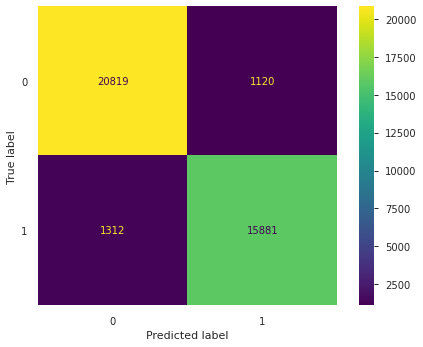

In [ ]:
plot_confusion_matrix(svm, X_test_svm, Y_test_svm)  
plt.show()  

In [ ]:
print(classification_report(Y_test_svm, y_pred_svm))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     21939
           1       0.93      0.92      0.93     17193

    accuracy                           0.94     39132
   macro avg       0.94      0.94      0.94     39132
weighted avg       0.94      0.94      0.94     39132



## 4.2 KNN (Juan Nunes)


Se aplicó  el algoritmo KNN, el cual es muy útil para predecir valores discretos, en el caso del requerimiento de negocio. Esto, mediante la busqueda de vecinos similares, donde a partir de ello pueda sacar conslusiones utiles para la toma de desiciones.


In [ ]:
X_train_knn, X_test_knn, Y_train_knn, Y_test_knn = train_test_split(X, Y, test_size=0.20, random_state=0)
#X_train_knn, Y_train_knn = balancer2.fit_resample(X_train_knn_p, Y_train_knn_p)
neigh = KNeighborsClassifier(n_neighbors=9,p=2)
neigh = neigh.fit(X_train_knn, Y_train_knn)
y_pred_knn = neigh.predict(X_test_knn)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


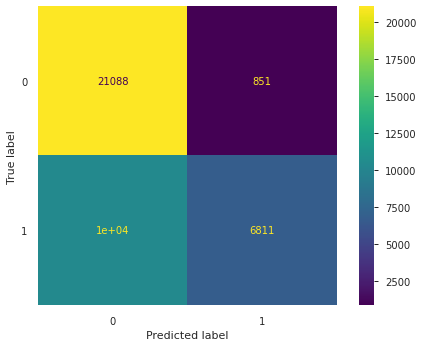

In [ ]:
plot_confusion_matrix(neigh, X_test_knn, Y_test_knn)  
plt.show()  

In [ ]:
print(classification_report(Y_test_knn, y_pred_knn))

              precision    recall  f1-score   support

           0       0.57      0.99      0.72     21939
           1       0.81      0.04      0.07     17193

    accuracy                           0.57     39132
   macro avg       0.69      0.52      0.40     39132
weighted avg       0.68      0.57      0.44     39132



## 4.3 Arboles de decisión (Gustavo Tabima)

---
Se aplicó Árboles de decisión teniendo como variable objetivo identificar la clase de un post en reddit, tomando como base las palabras claves con alegoría al suicidio (kill, pain, sadness, depression, etc) buscando así hallar cuales eran los posts que podían ser inferidos como alegorías al suicidio, lo encontrado es lo siguiente:


In [ ]:
X_train_arbol, X_test_arbol, Y_train_arbol, Y_test_arbol = train_test_split(X, Y, test_size=0.25, random_state=0)
# X_train_arbol, Y_train_arbol = balancer.fit_resample(X_train_arbol, Y_train_arbol)
# Hiperparametros finales de acuerdo al GirdSearch
arbol = DecisionTreeClassifier(criterion='gini', random_state=0, max_depth = 41, min_samples_split = 2)
arbol = arbol.fit(X_train_arbol,Y_train_arbol)
y_pred_arbol = arbol.predict(X_test_arbol)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


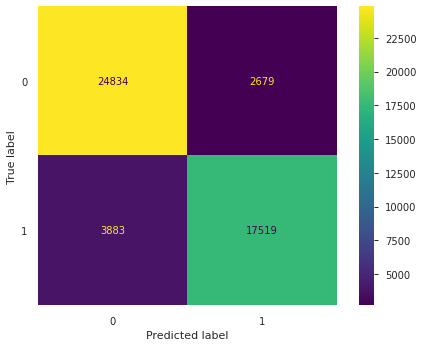

In [ ]:
plot_confusion_matrix(arbol, X_test_arbol, Y_test_arbol)  
plt.show()  

In [ ]:
print(classification_report(Y_test_arbol, y_pred_arbol))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     27513
           1       0.87      0.82      0.84     21402

    accuracy                           0.87     48915
   macro avg       0.87      0.86      0.86     48915
weighted avg       0.87      0.87      0.87     48915



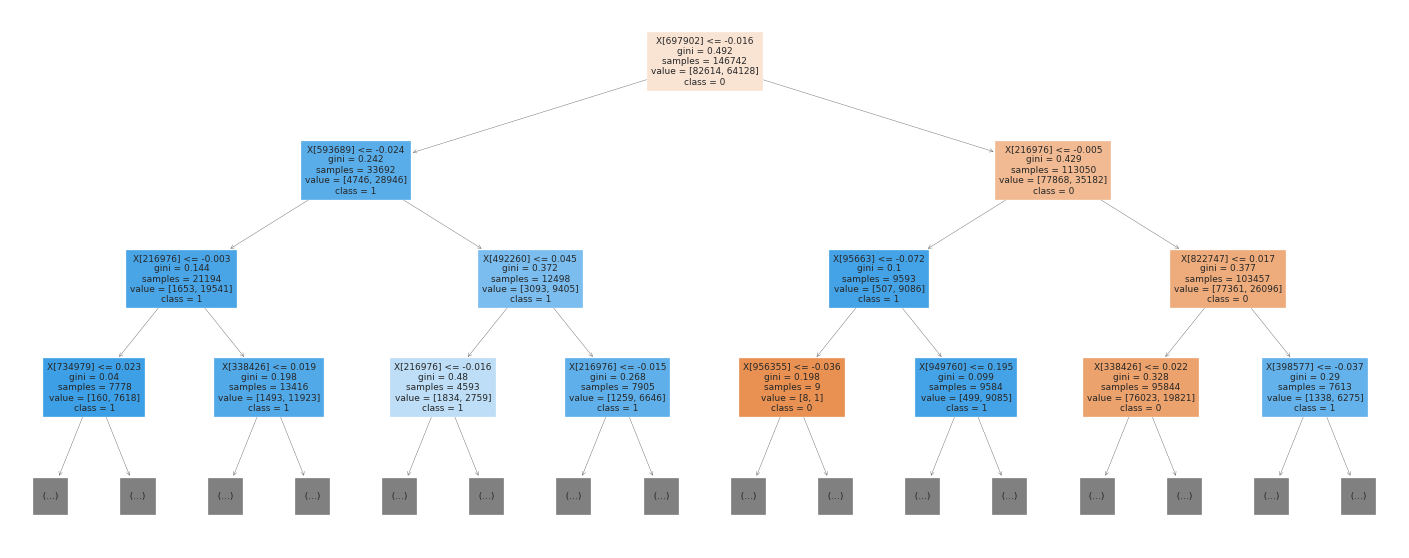

In [ ]:
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(arbol, max_depth=3, class_names=["0", "1"], filled=True, fontsize=9)

In [ ]:
# Manejamos el numero de particiones
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
# Matriz de parametros
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[38,39,40,41,42,43,44],'min_samples_split':[2, 3]}
# Creamos el arbol
arbol = DecisionTreeClassifier(random_state=0)
mejor_arbol = GridSearchCV(arbol, param_grid, cv=particiones)
# Ajuste del modelo
mejor_arbol.fit(X_train_arbol, Y_train_arbol)
# Obtener el mejor modelo.
arbol_final = mejor_arbol.best_estimator_
# Probemos ahora este modelo sobre test.
y_pred_train_arbol = arbol_final.predict(X_train_arbol)
y_pred_test_arbol = arbol_final.predict(X_test_arbol)

print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train_arbol, y_pred_train_arbol))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test_arbol, y_pred_test_arbol))

In [ ]:
# Hiperparametros finales
mejor_arbol.best_params_

## 4.4 Random Forest (Gustavo Tabima)
---

Se aplicó  RF teniendo como variable objetivo identificar la clase de un post en reddit, porque queríamos saber si ser pueden desenglosar algunas palabras y volverlas un denotador congruente para un post sobre suicidio, depronto una combinación precisa de palabras puede ser un post de suicidio acertado y nosotros no tenerlo previsto.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


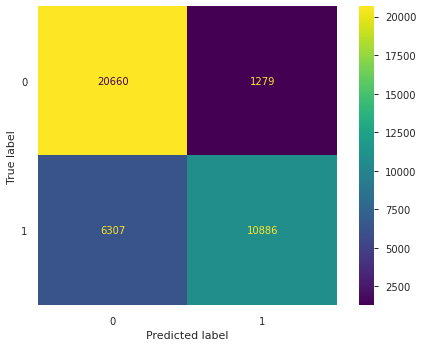

In [ ]:
X_train_rf, X_test_rf, Y_train_rf, Y_test_rf = train_test_split(X, Y, test_size=0.20, random_state=0)
#X_train_rf, Y_train_rf = balancer3.fit_resample(X_train_rf, Y_train_rf)
# Hiperparametros finales de acuerdo al GirdSearch
rf = RandomForestClassifier(n_estimators=100,criterion='entropy', random_state=0, max_depth = 41, min_samples_split = 3)
rf = rf.fit(X_train_rf,Y_train_rf)
y_pred_rf = rf.predict(X_test_rf)
# Vemos la matriz de confusiones.
plot_confusion_matrix(rf, X_test_rf, Y_test_rf)  
plt.show()

In [ ]:
print(classification_report(Y_test_rf, y_pred_rf))

              precision    recall  f1-score   support

           0       0.77      0.94      0.84     21939
           1       0.89      0.63      0.74     17193

    accuracy                           0.81     39132
   macro avg       0.83      0.79      0.79     39132
weighted avg       0.82      0.81      0.80     39132



In [ ]:
# Manejamos el numero de particiones
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
# Matriz de parametros
param_grid = {'n_estimators':[99,100],'criterion':['gini', 'entropy'],'max_depth':[38,40,42],'min_samples_split':[2,3,4]}
# Creamos el arbol
rf = RandomForestClassifier(random_state=0)
mejor_modelo = GridSearchCV(rf, param_grid, cv=particiones)
# Ajuste del modelo
mejor_modelo.fit(X_train_rf, Y_train_rf)
# Obtener el mejor modelo.
arbol_final = mejor_modelo.best_estimator_
# Probemos ahora este modelo sobre test.
y_pred_train = arbol_final.predict(X_train_rf)
y_pred_test = arbol_final.predict(X_test_rf)

print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train_rf, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test_rf, y_pred_test))

In [ ]:
mejor_modelo.best_params_

## 4.5 Baggin Classifer (César Moreno): 
---


  Para procesar los datos usamos también el modelo de Baggin Classifier, que es un metaclasificador enfocado en subsets aleatorios y genera predicciones, lo entrenamos para predecir diferentes casos de suicidio, para así presentar diferentes outcomes dependiendo de las palabras clave en los posts de Reddit.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


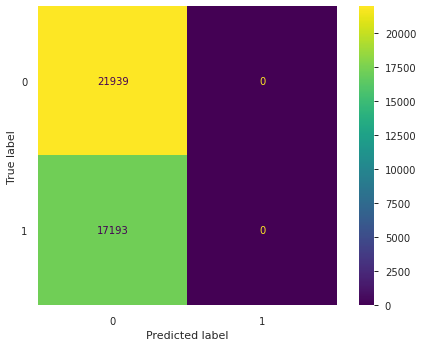

In [ ]:
X_train_bg, X_test_bg, Y_train_bg, Y_test_bg = train_test_split(X, Y, test_size=0.20, random_state=0)
#X_train_rf, Y_train_rf = balancer3.fit_resample(X_train_rf, Y_train_rf)
# Hiperparametros finales de acuerdo al GirdSearch
bagg = BaggingClassifier( max_features=10, max_samples=100, random_state=0, n_jobs=5)
bagg = bagg.fit(X_train_bg,Y_train_bg)
y_pred_bg = bagg.predict(X_test_bg)
# Vemos la matriz de confusiones.
plot_confusion_matrix(bagg, X_test_bg, Y_test_bg)  
plt.show()

In [ ]:
print(classification_report(Y_test_bg, y_pred_bg))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72     21939
           1       0.00      0.00      0.00     17193

    accuracy                           0.56     39132
   macro avg       0.28      0.50      0.36     39132
weighted avg       0.31      0.56      0.40     39132



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4.6 AdaBoostClassifier (Juan Nuñez)

Un modelo de machine learning que implemente AdaBoost es un metaestimador que ajusta inicialmente un clasificador en el conjunto de datos original, esto se usa para posteriomente volver mas eficientes otros estimadores y conseguir una sinergia entre modelos de machine learning.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


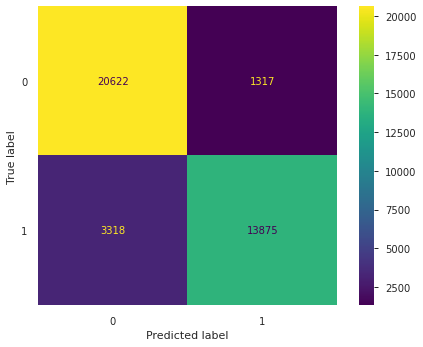

In [ ]:
X_train_ada, X_test_ada, Y_train_ada, Y_test_ada = train_test_split(X, Y, test_size=0.20, random_state=0)
#X_train_rf, Y_train_rf = balancer3.fit_resample(X_train_rf, Y_train_rf)
# Hiperparametros finales de acuerdo al GirdSearch
ada = AdaBoostClassifier( n_estimators=50, learning_rate=1)
ada = ada.fit(X_train_ada,Y_train_ada)
y_pred_ada = ada.predict(X_test_ada)
# Vemos la matriz de confusiones.
plot_confusion_matrix(ada, X_test_ada, Y_test_ada)  
plt.show()

In [ ]:
print(classification_report(Y_test_ada, y_pred_ada))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     21939
           1       0.91      0.81      0.86     17193

    accuracy                           0.88     39132
   macro avg       0.89      0.87      0.88     39132
weighted avg       0.88      0.88      0.88     39132



## 4.7 Bernoulli (César Moreno)

Este modelo de machine learning es una distribución de probabilidad discreta, lo que significa que solo considera variables aleatorias discretas.  Esto significa que no  analiza variables continuas, esto es muy importante porque el modelo permite predecir y etiquetar probabilisticamente la posibilidad de que un usuario se suicide o no. El resultado es  satisfactorio ya que se obtuvo cerca del 78% de accuracy.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


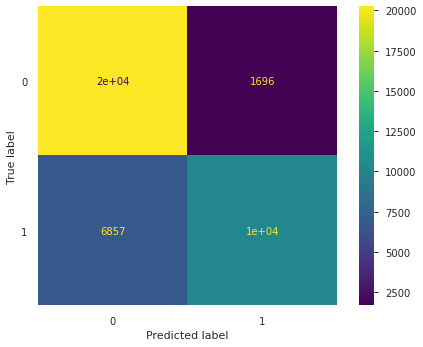

In [ ]:
X_train_ber, X_test_ber, Y_train_ber, Y_test_ber = train_test_split(X, Y, test_size=0.20, random_state=0)
#X_train_rf, Y_train_rf = balancer3.fit_resample(X_train_rf, Y_train_rf)
# Hiperparametros finales de acuerdo al GirdSearch
ber = BernoulliNB(alpha=1.0)
ber = ber.fit(X_train_ber,Y_train_ber)
y_pred_ber = ber.predict(X_test_ber)
# Vemos la matriz de confusiones.
plot_confusion_matrix(ber, X_test_ber, Y_test_ber)  
plt.show()

In [ ]:
print(classification_report(Y_test_ber, y_pred_ber))

              precision    recall  f1-score   support

           0       0.75      0.92      0.83     21939
           1       0.86      0.60      0.71     17193

    accuracy                           0.78     39132
   macro avg       0.80      0.76      0.77     39132
weighted avg       0.80      0.78      0.77     39132



# 5. Analisis de los modelos

## Arboles de decisión:
---
Se aplicó Árboles de decisión teniendo como variable objetivo identificar la clase de un post en reddit, tomando como base las palabras claves con alegoría al suicidio (kill, pain, sadness, depression, etc) buscando así hallar cuales eran los posts que podían ser inferidos como alegorías al suicidio.

Este modelo es muy bueno eligiendo los positivos adecuados, teniendo una precisión del 86%, creemos que le aporta valor a análisis de posts
dado que es capaz de elegir entre un post a partir de indicadores 
Claros del lenguaje natural que pueden ser de mucha utilidad
Para moderación o incluso ayuda por parte de admins
Del sub reddit de donde estamos analizando los datos.

## Random Forest:
---
Se aplicó  RF teniendo como variable objetivo identificar la clase de un post en reddit, porque queríamos saber si ser pueden desenglosar algunas palabras y volverlas un denotador congruente para un post sobre suicidio, depronto una combinación precisa de palabras puede ser un post de suicidio acertado y nosotros no tenerlo previsto.

Sin embargo este modelo resultó poco útil, dado que su precisión es menor a la requerida por nuesta selección de calidad, por esto decidimos dejarlo
De lado a la hora de escoger el mejor modelo.

## Support Vector Machine:
---
Después de aplicar SVM, vemos que este clasificar de fraccionamiento lineal, permite una creación en tiempos inigualables, y con indicadores casi ideales. Esto, lo vemos con nuestro indicador final de F1 de 94%, representando nuestro mejor modelo, y siendo el utilizado de forma definitiva.
## AdaBoost:
---
 AdaBoost es un metaclasificador que corrige en los datos originales  las ditancias entre las instancias con el fin de lograr modelos de machine learning mas optimizados. Nos arrojo una  mejora considerable y un accuracy del 90 %. Podemos concluir que es un modelo de machine learning muy util para mejorar  el rendimiento de modelos de clacificaion de aprendizaje no supervisado posteriores. La utilizacion de este metamodelo en casos donde el modelo se apoya en distancias como la distancia ecludiana causa una sinergia que  mejora la predicción.
## KNN:
---
Se aplico KNN sin hiperparametros y con hiperparametros. Este modelo encontro que los mejores prametros para el analisis son K = 9  y  2. Los resultados que encontramos sin los mejores parametros es un 0.55 de accuracy  y cuando tenemos los mejores  parametros 0.85. Este algoritmo probo que es productor de valiosas predicciones para el negocio; sin embargo, debido a  la importancia y relevancia del suicidio en nuestra socidad, es necesario seguir probando y entrenando modelos con el fin de encontrar  uno que nos permita encontrar con mayor precision a las personas que de verdad se planean suicidar.


## Bagging Classifier:
---
Luego de procesar el modelo podemos ver que su precisión es de menos del 60% por lo que vamos a descartarlo a la hora de escoger un modelo, Bagging resulta apropiado para este contexto de análisis de texto, pero no en este caso donde los subsets pueden brindar información poco concluyente dado que se necesita la linealidad del texto para generar un procesamiendo eficiente y concluyente.

## Bernulli:
---
Este modelo de machine learning  pertenece al grupo de los modelos que utilizan deep learning probabilistico.  La accuracy obtenida es del 78% y se uso en la variable objetivo  las variables discretas suicido y non suicidio, teniendo resultados satisfactorios mas no optimos. Aunque este es un problemas con variables discretas encontramos que no tiene suficiente exactitud en este caso de negocio. Creemos que esto se puede deber  a la interprteción necesaria para hacer PLN.

# 6. Selección del modelo final

Después de analizar los modelos propuestos llegamos a la conclusión de  que aunque todos los modelos de machine learning implmentados facilitan la tarea de prevencion, no  es viable por el nivel de calculo y procesamiento implementarlos todos. Algunos de los calculos tomaron varias horas siendo un subcojunto muy pequeño de una organización del tamaño de reddit. De este modo el modelo que escogemos para brindar una solución al negocio  es el de Support Vector Machine. Lo anterior es consecuencia primero, de la alta tasa de acierto, en el mejor de los casos 94% de acierto; segundo, la velocidad de procesamiento despues  de tranformado los datos, nos encontramos que por ejemplo con respecto a KNN es de cerca de 200 veces mas rapido, por lo que una aplicación directa en un servicio de moderación automática (como pasa por ejemplo con Facebook) logra volverse factible.

# 7. Conclusiones

Entre las conclusiones, podemos ver que encontramos una gran diversidad de tokens, donde los que cuentan con mayor frencuencia están mostrados en la siguiente imagen. Vemos que esto nos resalta los diferentes aspectos de la vida, que pueden influenciar a una persona depresiva, a contar con tendencias suicidas. Sin embargo, el tema de incurrencias puede no ser diciente para la toma de desiciones, el factor realmente importante, y motivo del estudio.

En este caso, vemos que existen palabras, como el high school, feel, dad y problem, que estando presentes no muestran nada en especifico, pero su utilización conjunta resulta demostrando una preocupación abrumadora.

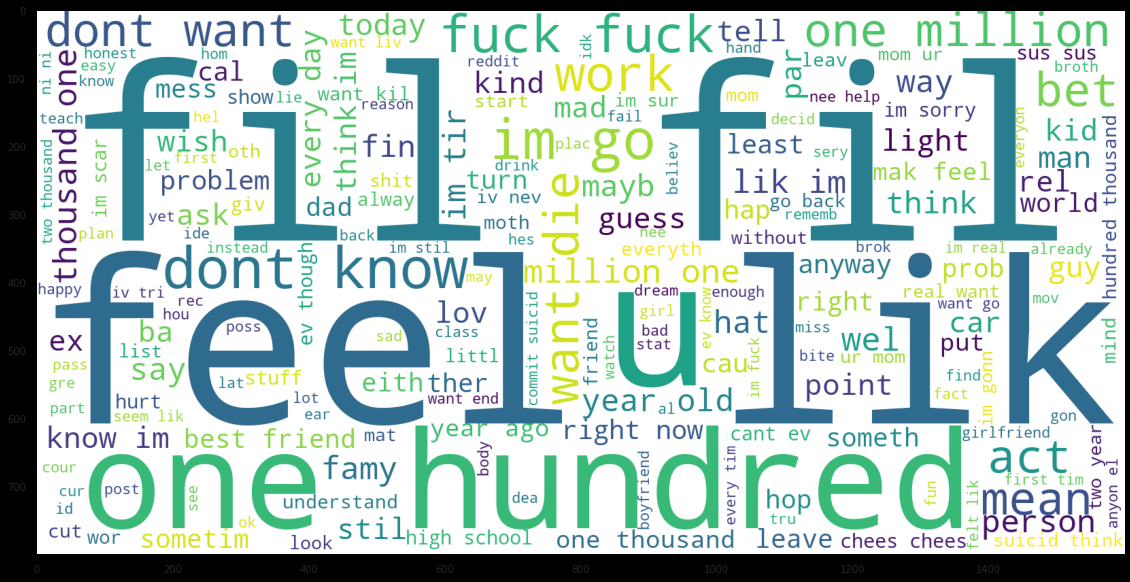

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(df_duplicado["processed"]))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

Buscando maximizar la utilidad del modelo, vemos que entre las palabras con los que contamos, son minimos los que tienen alta importancia, siendo estos los dicientes acerca de las tendencias suicidas. En total, como vemos en el grafico, es minimal el numero de palabras con importancia mayor a 4, siendo estos menos de 25, y menos de 60 con una importancia mayor a 3.

Eso nos permite crear una base de datos, que idenfifique directa e inmediatamente palabras que generen alertas para las personas encargadas de realizar primeros axuilios emocionales, resultando en acciones completamente efectivas.

Asimismo, vemos que el modelo SVM cuenta con tiempos de creación minimales, menores a 5 segundos, lo que permite que este mismo vaya siendo generado constantemente, adaptandose a los nuevos datos recibidos, escalando de forma impecable, en comparacion de los demás modelos.

Y por ultimo, se destaca que para su rapida identificación, esto no se hace de manera arbitraria, sino que se provee un sistema de manejo de hash que identifique una palabra, dado su token y su importancia en tiempo lineal, permitiendo que el los operadores puedan responder de forma eficaz a las necesidades de las personas. 

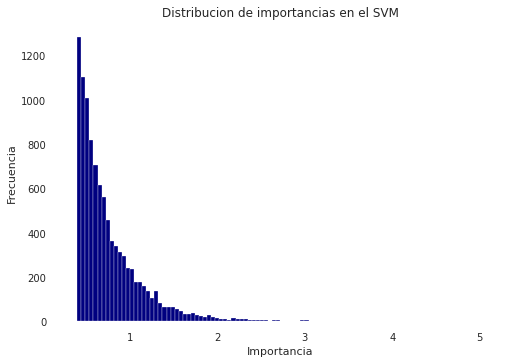

In [ ]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
pd.Series(abs(svm.coef_[0])).nlargest(10000).plot(kind='hist', color = 'navy',bins = 100)
plt.title("Distribucion de importancias en el SVM")
plt.xlabel("Importancia")
plt.ylabel("Frecuencia")
plt.show()